Ablation for Symphony on QM9!

In [10]:
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import chex
import functools
import pandas as pd
import e3nn_jax as e3nn
import posebusters
import sys
import os
import ase
import ase.io
import rdkit.Chem as Chem
import nglview as nv
sys.path.append("..")

In [11]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%autoreload 2
import sys
sys.path.append("../..")
from analyses.metrics import *

Paths:

In [13]:
generated_paths = {}
template = "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_ablation/e3schnet_and_nequip/interactions=3/l={lposition}/lfocus={lfocus}/position_channels={pc}/channels=64/fait=1.0/pit=1.0/step=best/molecules"
for lposition in range(1, 6):
    for lfocus in range(1, 3):
        for pc in range(1, 5):
            path = template.format(lposition=lposition, lfocus=lfocus, pc=pc)
            assert os.path.exists(path)
            generated_paths[(lposition, lfocus, pc)] = path

Corresponding molecules:

In [14]:
all_generated_molecules = {
    model: get_all_molecules(path) for model, path in generated_paths.items()
}

valid_molecules = {
    model: get_all_valid_molecules(molecules) for model, molecules in all_generated_molecules.items()
}

[19:52:31] Conflicting single bond directions around double bond at index 5.
[19:52:31]   BondStereo set to STEREONONE and single bond directions set to NONE.


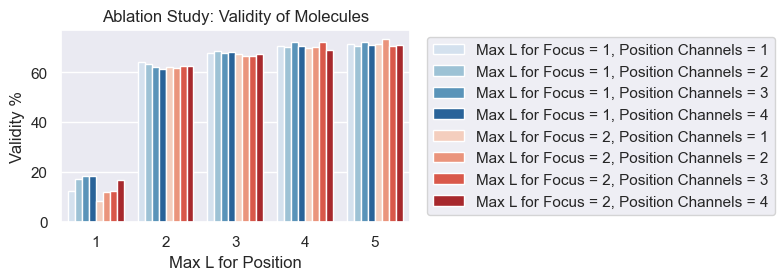

In [35]:
# Make a dataframe for each model for the validity of the molecules.
validity_df = pd.DataFrame(columns=["lposition", "lfocus", "pc", "validity"])

for model, molecules in valid_molecules.items():
    validity_fraction = compute_validity(all_generated_molecules[model], molecules)
    lposition, lfocus, pc = model

    validity_df = pd.concat(
        [
            validity_df,
            pd.DataFrame.from_records(
                [
                    {
                        "lposition": lposition,
                        "lfocus": lfocus,
                        "pc": pc,
                        "validity": validity_fraction,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

# Plot the validity of the molecules for each value of lposition.
validity_df['legend'] = validity_df['lfocus'].apply(lambda x: "Max L for Focus = {}".format(x)) + ", Position Channels = " + validity_df['pc'].apply(lambda x: str(x))
validity_df['validity_percent'] = validity_df['validity'] * 100.

my_palette = sns.color_palette("Blues", n_colors=4) + sns.color_palette("Reds", n_colors=4)

plt.figure(figsize=(4.5, 2.5))
sns.set_theme(style="darkgrid")
sns.barplot(
    data=validity_df, x="lposition", y="validity_percent",
    hue="legend", palette=my_palette
)
plt.title("Ablation Study: Validity of Molecules")
plt.xlabel("Max L for Position")
plt.ylabel("Validity %")
# Place legend outside the figure/plot, centered vertically.
plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0.)
plt.savefig("validity_ablation.pdf", dpi=500, bbox_inches="tight")
plt.show()

In [16]:
formatted_validity_df = validity_df.transpose()
formatted_validity_df.columns = formatted_validity_df.iloc[0]
formatted_validity_df *= 100
formatted_validity_df = formatted_validity_df.drop("model")
formatted_validity_df = formatted_validity_df.astype(float)
formatted_validity_df = formatted_validity_df.round(2)
formatted_validity_df = formatted_validity_df.astype(str)
print(formatted_validity_df.style.to_latex())

KeyError: "['model'] not found in axis"